# Emmanuel Nhyira RNN-LSTM implemantation
# Adopted from A. Toro-Ossaba, J. Jaramillo-Tigreros, J. C. Tejada, A. Peña, A. López-González, and R. A. Castanho, “LSTM Recurrent Neural Network for Hand Gesture Recognition Using EMG Signals,” 2022, doi: 10.3390/app12199700.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import scipy.io

#loading data
path = '/content/drive/MyDrive/Session1_converted'
subject_id = 0
data = scipy.io.loadmat(f'{path}/session1_participant{subject_id+1}.mat')  #files are usually numbered 1.mat, 2.mat, etc.

#extracting forearm EMG data
data_forearm = data['DATA_FOREARM']  #shape: (7 trials, 17 gestures)


In [ ]:
data_forearm.shape

(7, 17)

In [ ]:
#target gestures(zero-indexed)
target_gesture_indices = [6, 14, 15, 16]  #'Index and Middle Finger Extension', 'Hand Open', 'Hand Close', 'Rest'

#channels to keep(zero-indexed: 0,1,6)
selected_channels = [0, 1, 6]

#Window settings
sampling_rate = 1000  #after downsampling
window_size = int(0.2 * sampling_rate)  #200ms windows so 200 samples

In [ ]:
#target gestures(zero-indexed)
target_gesture_indices = [6, 14, 15, 16]  #'Index and Middle Finger Extension', 'Hand Open', 'Hand Close', 'Rest'

#channels to keep(zero-indexed: 0,1,6)
selected_channels = [0, 1, 6]

def preprocess_emg(window, sampling_rate=1000):
    #mean removal(zero-mean)
    window = window - np.mean(window, axis=0)

    #rectification(absolute value)
    window = np.abs(window)

    #moving average smoothing(10ms window = 10 samples at 1000 Hz)
    window_size_smooth = int(0.01 * sampling_rate)
    smoothed_window = np.zeros_like(window)
    for ch in range(window.shape[1]):
        smoothed_window[:, ch] = np.convolve(window[:, ch], np.ones(window_size_smooth)/window_size_smooth, mode='same')

    #normalization(0 to 1 scaling per channel)
    min_vals = np.min(smoothed_window, axis=0)
    max_vals = np.max(smoothed_window, axis=0)
    normalized_window = (smoothed_window - min_vals) / (max_vals - min_vals + 1e-8)

    return normalized_window

In [ ]:
X = []
y = []

for gesture_idx in target_gesture_indices:
    #concatenate all 7 trials
    concatenated_emg = []

    for trial_idx in range(7):
        emg_data = data_forearm[trial_idx, gesture_idx]  #shape: (10240, 16)

        #downsample from 2048 Hz to 1000 Hz(by taking every second sample)
        emg_data_downsampled = emg_data[::2]

        #only selected channels
        emg_data_selected = emg_data_downsampled[:, selected_channels]  #shape: (5120, 3)

        concatenated_emg.append(emg_data_selected)

    #stacking all trials vertically so (5120*7, 3) = (35840, 3)
    gesture_data = np.vstack(concatenated_emg)

    #splitting into non-overlapping windows
    num_windows = gesture_data.shape[0] // window_size

    for i in range(0, num_windows * window_size, window_size):
        window = gesture_data[i:i + window_size, :]  #shape: (200, 3)

        #preprocess
        window_processed = preprocess_emg(window, sampling_rate=1000)

        X.append(window_processed)
        y.append(target_gesture_indices.index(gesture_idx))  #label: 0,1,2,3

#converting to numpy arrays
X = np.array(X)  #(num_samples, 200, 3)
y = np.array(y)  #(num_samples,)

print("Final dataset shapes:", X.shape, y.shape)

Final dataset shapes: (716, 200, 3) (716,)


In [ ]:
X

array([[[2.67213840e-02, 0.00000000e+00, 2.15159934e-04],
        [1.42152369e-01, 1.06550306e-01, 6.99723156e-02],
        [1.90097849e-01, 1.66018948e-01, 9.20303394e-02],
        ...,
        [4.33699122e-02, 1.48614659e-01, 1.26837902e-02],
        [2.58726820e-02, 8.57154199e-02, 5.81386044e-03],
        [0.00000000e+00, 1.37850446e-02, 0.00000000e+00]],

       [[5.03246096e-01, 2.44868374e-01, 5.53497928e-01],
        [5.29875487e-01, 2.64742312e-01, 6.05953958e-01],
        [6.33827736e-01, 3.28168288e-01, 7.00006103e-01],
        ...,
        [1.75006508e-01, 2.02788271e-01, 2.23176309e-01],
        [1.72787562e-01, 1.90505993e-01, 2.12029627e-01],
        [1.57400544e-01, 1.67236286e-01, 1.79682041e-01]],

       [[1.41932295e-01, 5.93722744e-01, 5.08116714e-02],
        [1.70664616e-01, 6.25730992e-01, 7.32316263e-02],
        [2.90194845e-01, 6.98144830e-01, 1.77280880e-01],
        ...,
        [2.80921365e-02, 2.39803107e-02, 1.95429049e-02],
        [2.07428501e-02, 1.12

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

#adjusting dataset class to ensure proper shape
class EMGDataset(Dataset):
    def __init__(self, X, y):
        #X shape: (num_samples, window_size=200, channels=3)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

def prepare_data():
    #normalize globally across all samples
    X_mean = np.mean(X, axis=(0, 1), keepdims=True)
    X_std = np.std(X, axis=(0, 1), keepdims=True)
    X_normalized = (X - X_mean) / (X_std)

    #splitting data
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

    #create datasets and dataloaders
    train_dataset = EMGDataset(X_train, y_train)
    test_dataset = EMGDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader,X_train, X_test, y_train, y_test

In [ ]:
# from sklearn.utils import shuffle

# X, y = shuffle(X, y, random_state=42)
train_loader, test_loader, X_train, X_test, y_train, y_test= prepare_data()

In [ ]:
EMGDataset

__main__.EMGDataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HybridDenseLSTM(nn.Module):
    def __init__(self, input_size=3, num_classes=4, hidden_size=16):
        super(HybridDenseLSTM, self).__init__()

        #first Dense Layer
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.3)

        #LSTM Layer
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size,
                            num_layers=1, batch_first=True, dropout=0)

        #second Dense Layer
        self.fc2 = nn.Linear(hidden_size, 32)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)

        #output Layer
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        #if input is (batch, channels, sequence_length), permute to (batch, sequence_length, channels)
        if x.shape[1] == 3 and x.shape[2] == 200:
            x = x.permute(0, 2, 1)  #[batch, seq_len, channels]

        #first Dense layer on each time step
        x = self.fc1(x)
        x = self.relu(x)
        #flatten for batch norm
        x = x.view(-1, 32)
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = x.view(-1, 200, 32)  #reshape back to (batch, seq_len, features)

        #LSTM
        lstm_out, _ = self.lstm(x)

        #take output at last time step
        x = lstm_out[:, -1, :]  #(batch, hidden_size=16)

        #second Dense layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        #output layer
        x = self.fc3(x)

        return x


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def train_improved_model(model, train_loader, test_loader, epochs=300):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    #use a more robust optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    #yse CosineAnnealing scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    #initializing lists for tracking
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    #early stopping setup
    best_val_loss = float('inf')
    patience = 15
    counter = 0

    for epoch in range(epochs):
        #training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()

            #gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            #tracking metrics
            _, predicted = torch.max(outputs, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()
            running_loss += loss.item()

        #calculating training metrics
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(running_loss / len(train_loader))

        #validation
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += y_batch.size(0)
                correct_val += (predicted == y_batch).sum().item()

        #calculating validation metrics
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss / len(test_loader))

        #update learning rate
        scheduler.step()

        #early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            counter = 0
            torch.save(model.state_dict(), 'best_emg_model.pt')
        else:
            counter += 1
            if counter >= patience and epoch > 50:
                print(f"Early stopping at epoch {epoch+1}")
                break

        #print status every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, LR: {scheduler.get_last_lr()[0]:.6f}')
            print(f'Training Loss: {train_losses[-1]:.4f}, Acc: {train_accuracy:.2f}%')
            print(f'Validation Loss: {val_losses[-1]:.4f}, Acc: {val_accuracy:.2f}%')
            print('-' * 40)

    # Load best model for evaluation
    model.load_state_dict(torch.load('best_emg_model.pt'))

    #plot results
    plot_training_validation_accuracy(train_accuracies, val_accuracies)
    plot_training_validation_loss(train_losses, val_losses)

    #evaluate final model
    evaluate_model(model, test_loader)

def plot_training_validation_accuracy(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

def plot_training_validation_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Accuracy
    # acc = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    # print(f"Test Accuracy: {acc*100:.2f}%")

    #confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['IndexMidExt', 'HandOpen', 'HandClose', 'Rest'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [ ]:
import itertools

def grid_search_hyperparameters():
    #define parameter grid
    param_grid = {
        'learning_rate': [0.01, 0.001, 0.0001],
        'batch_size': [16, 32, 64],
        'dropout': [0.2, 0.3, 0.5],
        'hidden_size': [32, 64, 128]
    }

    #generate all combinations
    keys = param_grid.keys()
    combinations = list(itertools.product(*[param_grid[key] for key in keys]))

    #track best performance
    best_val_acc = 0
    best_params = None

    #test each combination
    for i, combo in enumerate(combinations):
        params = dict(zip(keys, combo))
        print(f"Testing combination {i+1}/{len(combinations)}: {params}")

        #create model with current params
        model = HybridDenseLSTM(
            input_size=3,
            hidden_size=params['hidden_size'],
        )

        #create dataloaders with current batch size
        train_dataset = EMGDataset(X_train, y_train)
        test_dataset = EMGDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

        #train for fewer epochs in grid search
        val_acc = quick_train_evaluate(
            model, train_loader, test_loader,
            learning_rate=params['learning_rate'],
            dropout=params['dropout']
        )

        #update best if improved
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params

    print(f"Best parameters: {best_params} with validation accuracy: {best_val_acc:.2f}%")
    return best_params

def quick_train_evaluate(model, train_loader, test_loader, learning_rate, dropout, epochs=200):
    """
    Shortened version of training function for hyperparameter tuning.
    Returns validation accuracy for grid search comparison.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    #dropout values for all layers that have dropout
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = dropout

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    #early stopping
    best_val_loss = float('inf')
    best_val_acc = 0
    patience = 5
    counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        #validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)

                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        #calculate validation metrics
        current_val_loss = val_loss / len(test_loader)
        current_val_acc = 100 * correct / total

        #early stopping check
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            best_val_acc = current_val_acc
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                #early stopping triggered
                break

        #print only every 10 epochs to reduce output
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Val Acc: {current_val_acc:.2f}%")

    print(f"Completed training with final validation accuracy: {best_val_acc:.2f}%")
    return best_val_acc

Epoch 10/300, LR: 0.000997
Training Loss: 1.3722, Acc: 29.20%
Validation Loss: 1.3849, Acc: 31.94%
----------------------------------------
Epoch 20/300, LR: 0.000989
Training Loss: 1.2971, Acc: 37.59%
Validation Loss: 1.3469, Acc: 35.42%
----------------------------------------
Epoch 30/300, LR: 0.000976
Training Loss: 1.2331, Acc: 43.18%
Validation Loss: 1.2923, Acc: 38.89%
----------------------------------------
Epoch 40/300, LR: 0.000957
Training Loss: 1.1366, Acc: 49.65%
Validation Loss: 1.2167, Acc: 46.53%
----------------------------------------
Epoch 50/300, LR: 0.000933
Training Loss: 1.0587, Acc: 53.32%
Validation Loss: 1.0953, Acc: 45.14%
----------------------------------------
Epoch 60/300, LR: 0.000905
Training Loss: 1.0051, Acc: 54.90%
Validation Loss: 1.0492, Acc: 54.17%
----------------------------------------
Epoch 70/300, LR: 0.000872
Training Loss: 0.9361, Acc: 58.74%
Validation Loss: 1.0134, Acc: 53.47%
----------------------------------------
Epoch 80/300, LR: 0.

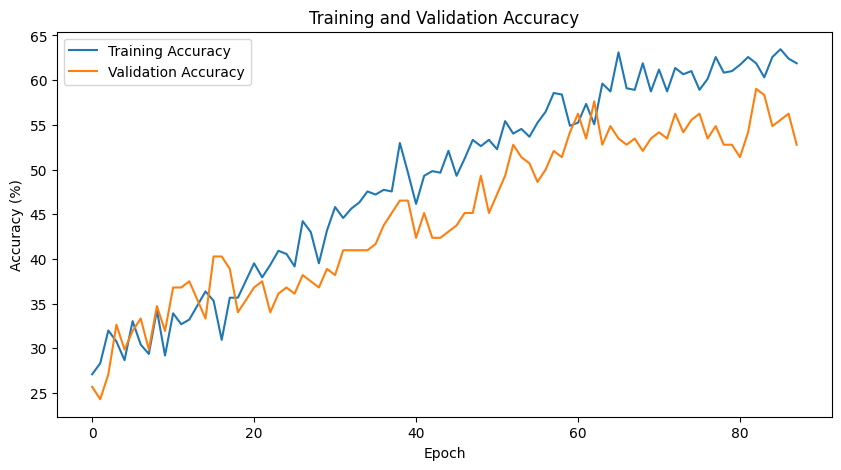

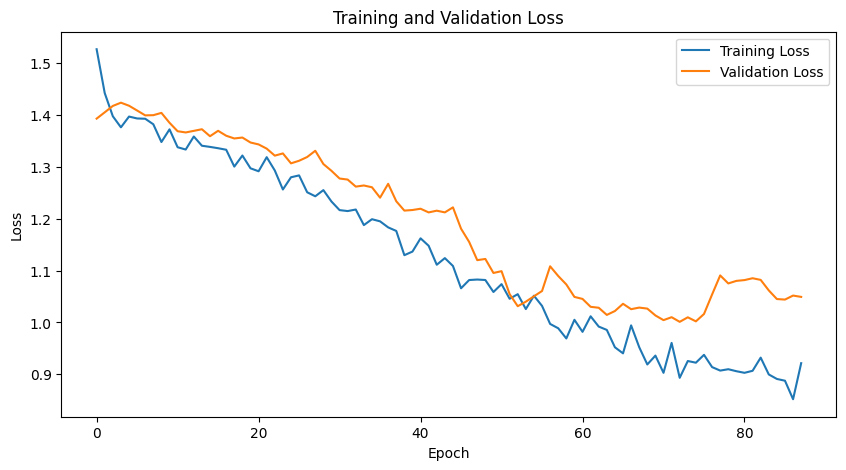

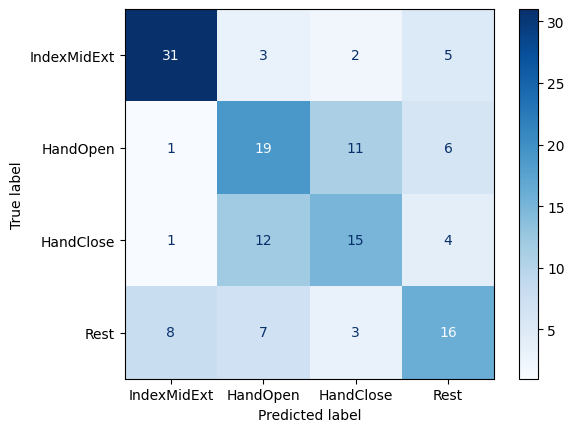

In [ ]:
#LSTM-RNN model
lstm_rnn_model = HybridDenseLSTM(num_classes=4)
train_improved_model(lstm_rnn_model, train_loader, test_loader, epochs=300)

In [ ]:
best_params = grid_search_hyperparameters()

Testing combination 1/81: {'learning_rate': 0.01, 'batch_size': 16, 'dropout': 0.2, 'hidden_size': 32}
Epoch 10/200 - Val Acc: 43.06%
Completed training with final validation accuracy: 42.36%
Testing combination 2/81: {'learning_rate': 0.01, 'batch_size': 16, 'dropout': 0.2, 'hidden_size': 64}
Epoch 10/200 - Val Acc: 43.75%
Epoch 20/200 - Val Acc: 57.64%
Completed training with final validation accuracy: 57.64%
Testing combination 3/81: {'learning_rate': 0.01, 'batch_size': 16, 'dropout': 0.2, 'hidden_size': 128}
Epoch 10/200 - Val Acc: 38.19%
Completed training with final validation accuracy: 38.89%
Testing combination 4/81: {'learning_rate': 0.01, 'batch_size': 16, 'dropout': 0.3, 'hidden_size': 32}
Epoch 10/200 - Val Acc: 42.36%
Epoch 20/200 - Val Acc: 50.69%
Completed training with final validation accuracy: 55.56%
Testing combination 5/81: {'learning_rate': 0.01, 'batch_size': 16, 'dropout': 0.3, 'hidden_size': 64}
Epoch 10/200 - Val Acc: 40.97%
Epoch 20/200 - Val Acc: 54.17%
Comp

## Training Final Model

In [ ]:
def train_improved_model(model, train_loader, test_loader, learning_rate=0.001, epochs=200):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    #learning rate from best parameters
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    #scheduler setup
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    #tracking metrics
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    #early stopping
    best_val_loss = float('inf')
    patience = 15
    counter = 0

    for epoch in range(epochs):
        #training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()

            #gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            #tracking metrics
            _, predicted = torch.max(outputs, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()
            running_loss += loss.item()

        #calculate training metrics
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(running_loss / len(train_loader))

        #validation
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += y_batch.size(0)
                correct_val += (predicted == y_batch).sum().item()

        #calculate validation metrics
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss / len(test_loader))

        #update learning rate
        scheduler.step()

        # #early stopping
        # if val_losses[-1] < best_val_loss:
        #     best_val_loss = val_losses[-1]
        #     counter = 0
        #     torch.save(model.state_dict(), 'best_emg_model.pt')
        # else:
        #     counter += 1
        #     if counter >= patience and epoch > 50:
        #         print(f"Early stopping at epoch {epoch+1}")
        #         break

        #print status
        print(f'Epoch {epoch+1}/{epochs}, LR: {scheduler.get_last_lr()[0]:.6f}')
        print(f'Training Loss: {train_losses[-1]:.4f}, Acc: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_losses[-1]:.4f}, Acc: {val_accuracy:.2f}%')
        print('-' * 40)

    #load best model for evaluation
    model.load_state_dict(torch.load('best_emg_model.pt'))

    #plot results
    plot_training_validation_accuracy(train_accuracies, val_accuracies)
    plot_training_validation_loss(train_losses, val_losses)

    #evaluate final model
    evaluate_model(model, test_loader)
    torch.save(model.state_dict(), 'best_emg_model.pt')

    #return the final model and training history
    return model, {
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_losses': train_losses,
        'val_losses': val_losses
    }

In [ ]:
def train_final_model(best_params):
    """
    Train the final model using the best hyperparameters found from grid search.

    Args:
        best_params: Dictionary containing the best hyperparameters

    Returns:
        Trained model
    """
    print("Training final model with best parameters:")
    print(best_params)

    #create model with best parameters
    final_model = HybridDenseLSTM(
        input_size=3,
        hidden_size=best_params['hidden_size'] #use best hidden_size from grid search
    )

    #dropout for all dropout layers
    for module in final_model.modules():
        if isinstance(module, nn.Dropout):
            module.p = best_params['dropout']

    #create dataloaders with optimal batch size
    train_dataset = EMGDataset(X_train, y_train)
    test_dataset = EMGDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

    #train the model with full training process
    train_improved_model(
        final_model,
        train_loader,
        test_loader,
        learning_rate=best_params['learning_rate'],
        epochs=200  #use more epochs for final training
    )

    return final_model

In [ ]:
#training the final model with best parameters
final_model = train_final_model(best_params)

#saving the final model
torch.save(final_model.state_dict(), 'final_emg_gesture_model.pt')

#evaluate on test set
print("Final evaluation on test set:")
evaluate_model(final_model, test_loader)

Training final model with best parameters:
{'learning_rate': 0.01, 'batch_size': 32, 'dropout': 0.2, 'hidden_size': 128}
Epoch 1/200, LR: 0.009999
Training Loss: 1.4659, Acc: 27.97%
Validation Loss: 1.4828, Acc: 21.53%
----------------------------------------
Epoch 2/200, LR: 0.009998
Training Loss: 1.3948, Acc: 32.17%
Validation Loss: 1.3323, Acc: 33.33%
----------------------------------------
Epoch 3/200, LR: 0.009994
Training Loss: 1.3184, Acc: 35.66%
Validation Loss: 1.2771, Acc: 29.17%
----------------------------------------
Epoch 4/200, LR: 0.009990
Training Loss: 1.3153, Acc: 35.49%
Validation Loss: 1.4368, Acc: 28.47%
----------------------------------------
Epoch 5/200, LR: 0.009985
Training Loss: 1.2844, Acc: 36.19%
Validation Loss: 1.2848, Acc: 40.97%
----------------------------------------
Epoch 6/200, LR: 0.009978
Training Loss: 1.1474, Acc: 42.31%
Validation Loss: 1.0830, Acc: 47.22%
----------------------------------------
Epoch 7/200, LR: 0.009970
Training Loss: 1.07

RuntimeError: Error(s) in loading state_dict for HybridDenseLSTM:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([512, 32]).
	size mismatch for lstm.weight_hh_l0: copying a param with shape torch.Size([64, 16]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for lstm.bias_ih_l0: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for lstm.bias_hh_l0: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([32, 128]).

In [ ]:
def predict_gesture(model, emg_signal):
    """
    Use the trained model to predict gestures from new EMG signals.

    Args:
        model: Trained model
        emg_signal: Preprocessed EMG signal with shape [sequence_length, channels]
                   or [batch, sequence_length, channels]

    Returns:
        Predicted gesture index and probabilities
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()


    if len(emg_signal.shape) == 2:
        emg_signal = np.expand_dims(emg_signal, 0)

    #convert to tensor
    emg_tensor = torch.tensor(emg_signal, dtype=torch.float32).to(device)

    #make prediction
    with torch.no_grad():
        outputs = model(emg_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    #convert to numpy
    predicted_gesture = predicted.cpu().numpy()[0]
    probabilities = probabilities.cpu().numpy()[0]

    #map index to gesture name
    gesture_names = ['Index/Middle Finger Extension', 'Hand Open', 'Hand Close', 'Rest']
    predicted_gesture_name = gesture_names[predicted_gesture]

    return {
        'gesture_index': predicted_gesture,
        'gesture_name': predicted_gesture_name,
        'confidence': probabilities[predicted_gesture],
        'all_probabilities': probabilities
    }

In [ ]:
# Load your trained model
#loaded_model = ImprovedEMG_LSTM(input_size=3, hidden_size=best_params['hidden_size'])
loaded_model = ImprovedEMG_LSTM(input_size=3, hidden_size=64)
loaded_model.load_state_dict(torch.load('final_emg_gesture_model.pt'))

#using a single test example
test_emg = X_test[5]  # Get a test sample
result = predict_gesture(loaded_model, test_emg)
print(f"Predicted gesture: {result['gesture_name']} with {result['confidence']:.2f} confidence")

#confusion matrix on test set
evaluate_model(loaded_model, test_loader)

In [ ]:
#test on multiple examples
num_samples = 10  #number of test samples to evaluate

for i in range(min(num_samples, len(X_test))):
    test_emg = X_test[i]
    test_label = y_test[i]

    true_gesture_name = gesture_names[test_label]
    result = predict_gesture(loaded_model, test_emg)

    print(f"\nSample {i+1}:")
    print(f"Predicted: {result['gesture_name']} (Confidence: {result['confidence']:.2f})")
    print(f"Actual: {true_gesture_name}")

    #if the prediction is wrong, highlight it
    if result['gesture_index'] != test_label:
        print("*** INCORRECT PREDICTION ***")